In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DateType, IntegerType
from pyspark.sql.functions import date_format
from pyspark.sql.functions import sum, when, col, row_number
from pyspark.sql.window import Window
import yfinance as yf
import numpy as np

In [2]:
# Initialize a SparkSession
spark = SparkSession.builder.appName("CongressTrading").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/03 16:09:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/03 16:09:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
schema = StructType([
    StructField("ReportDate", DateType(), True),
    StructField("TransactionDate", DateType(), True),
    StructField("Ticker", StringType(), True),
    StructField("Representative", StringType(), True),
    StructField("Transaction", StringType(), True),
    StructField("Amount", IntegerType(), True),
    StructField("Party", StringType(), True),
    StructField("House", StringType(), True),
    StructField("Range", StringType(), True)
])


In [4]:
df = spark.read.csv("congress-trading-all.csv", header=True, schema=schema)

In [5]:
df.show()

23/10/03 16:09:33 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 10, schema size: 9
CSV file: file:///Users/suhasyogish/Documents/Big%20Data/Project/Altenative%20Data/congress-trading-all.csv


+----------+---------------+------+------------------+-----------+------+-----+---------------+---------------+
|ReportDate|TransactionDate|Ticker|    Representative|Transaction|Amount|Party|          House|          Range|
+----------+---------------+------+------------------+-----------+------+-----+---------------+---------------+
|2023-09-18|     2023-04-19|   CCK|Thomas H. Kean Jr.|   Purchase|  1001|    R|Representatives| $1,001-$15,000|
|2023-09-18|     2023-05-04|   FIS|Thomas H. Kean Jr.|       Sale|  1001|    R|Representatives| $1,001-$15,000|
|2023-09-18|     2023-06-12|   FIS|Thomas H. Kean Jr.|   Purchase|  1001|    R|Representatives| $1,001-$15,000|
|2023-09-18|     2023-04-03|   JPM|Thomas H. Kean Jr.|   Purchase|  1001|    R|Representatives| $1,001-$15,000|
|2023-09-18|     2023-06-12|   GPN|Thomas H. Kean Jr.|       Sale|  1001|    R|Representatives| $1,001-$15,000|
|2023-09-18|     2023-07-31|   DHR|Thomas H. Kean Jr.|   Purchase|  1001|    R|Representatives| $1,001-$

In [6]:
df = df.withColumn("TransactionDateMMYYYY", date_format(df["TransactionDate"], "yyyy-MM"))

In [7]:
# Group by yyyy-MM and calculate total purchases and total sales
result_df = df.groupBy("TransactionDateMMYYYY", "Ticker").agg(
    sum(when(col("Transaction") == "Purchase", col("Amount"))).alias("TotalPurchases"),
    sum(when(col("Transaction") == "Sale", col("Amount"))).alias("TotalSales")
)

# Calculate the rank of maximum purchases and sales for each month
window_spec_purchase = Window.partitionBy("TransactionDateMMYYYY").orderBy(col("TotalPurchases").desc())
window_spec_sale = Window.partitionBy("TransactionDateMMYYYY").orderBy(col("TotalSales").desc())

result_df = result_df.withColumn("RankPurchase", row_number().over(window_spec_purchase))
result_df = result_df.withColumn("RankSale", row_number().over(window_spec_sale))

# Filter for the stocks with the maximum purchase and maximum sale amounts for each month
most_purchased_stocks = result_df.filter(col("RankPurchase") == 1).select("TransactionDateMMYYYY", "Ticker", "TotalPurchases")
most_sold_stocks = result_df.filter(col("RankSale") == 1).select("TransactionDateMMYYYY", "Ticker", "TotalSales")

# Rename the first Ticker column to TickerPurchase and TickerSale
most_purchased_stocks = most_purchased_stocks.withColumnRenamed("Ticker", "TickerPurchase")
most_sold_stocks = most_sold_stocks.withColumnRenamed("Ticker", "TickerSale")

# Show the most purchased and most sold stocks for each unique yyyy-MM
most_purchased_stocks.show()
most_sold_stocks.show()


+---------------------+--------------+--------------+
|TransactionDateMMYYYY|TickerPurchase|TotalPurchases|
+---------------------+--------------+--------------+
|              2014-07|          AMAT|          NULL|
|              2014-08|          CNHI|          NULL|
|              2014-10|           CHK|          3003|
|              2014-11|           SLB|          1001|
|              2015-01|           AUY|          NULL|
|              2015-03|            BK|          NULL|
|              2015-05|           MSM|         16002|
|              2015-06|            ST|         16002|
|              2015-07|           APD|         15001|
|              2015-09|          DORM|         16002|
|              2015-12|          FITB|         16002|
|              2016-01|          AAPL|         89012|
|              2016-02|           MCD|         50001|
|              2016-03|            FB|         51002|
|              2016-04|           VLO|        100001|
|              2016-05|     

In [8]:
# Join most_purchased_stocks and most_sold_stocks on TransactionDateMMYYYY
joined_df = most_purchased_stocks.join(
    most_sold_stocks,
    on="TransactionDateMMYYYY",
    how="inner"  # You can use "inner" for an inner join or "outer" for an outer join, depending on your requirements
)

# Sort the joined_df DataFrame in descending order by TransactionDateMMYYYY
sorted_df = joined_df.orderBy(joined_df["TransactionDateMMYYYY"].desc())

# Show the sorted DataFrame
sorted_df.show()

+---------------------+--------------+--------------+----------+----------+
|TransactionDateMMYYYY|TickerPurchase|TotalPurchases|TickerSale|TotalSales|
+---------------------+--------------+--------------+----------+----------+
|              2023-09|            AI|          NULL|        AI|      NULL|
|              2023-08|           NGL|        250001|      MSFT|    750002|
|              2023-07|           CLF|         50001|       NVO|    350002|
|              2023-06|          MSFT|        501002|        ET|    701005|
|              2023-05|          PYPL|        501003|      AAPL|    501002|
|              2023-04|             F|        130003|         X|    151003|
|              2023-03|          AAPL|        515002|     FWONK|    550002|
|              2023-02|            BX|         30002|       PXD|   1000001|
|              2023-01|           CRM|        101002|      MSFT|   1067005|
|              2022-12|          PYPL|        265002|     GOOGL|   1500003|
|           

23/10/03 16:09:40 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


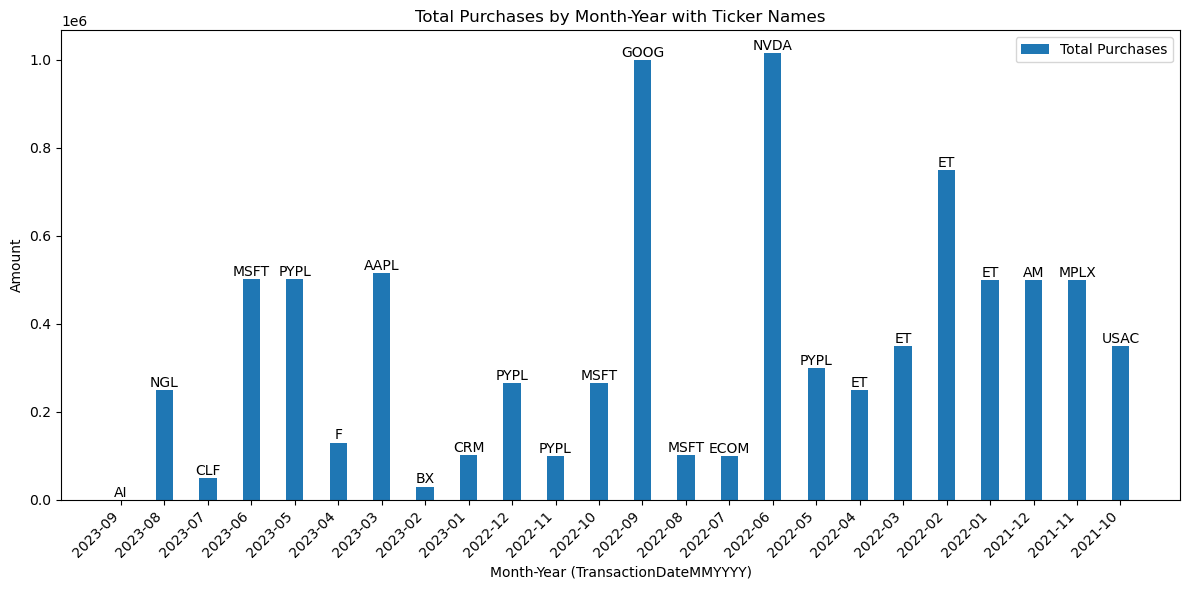

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import when

# Replace NULL values in sorted_df with 0 for TotalPurchases
sorted_df = sorted_df.fillna(0, subset=["TotalPurchases"])

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
pandas_df = sorted_df.limit(24).toPandas()

# Plot total purchases
plt.figure(figsize=(12, 6))
bars = plt.bar(
    pandas_df["TransactionDateMMYYYY"], pandas_df["TotalPurchases"], 
    width=0.4, label="Total Purchases", align="center"
)

# Add ticker names as data labels above the bars
for i, bar in enumerate(bars):
    ticker = pandas_df["TickerPurchase"].iloc[i]
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 100, ticker, ha="center", va="bottom")

plt.xlabel("Month-Year (TransactionDateMMYYYY)")
plt.ylabel("Amount")
plt.title("Total Purchases by Month-Year with Ticker Names")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


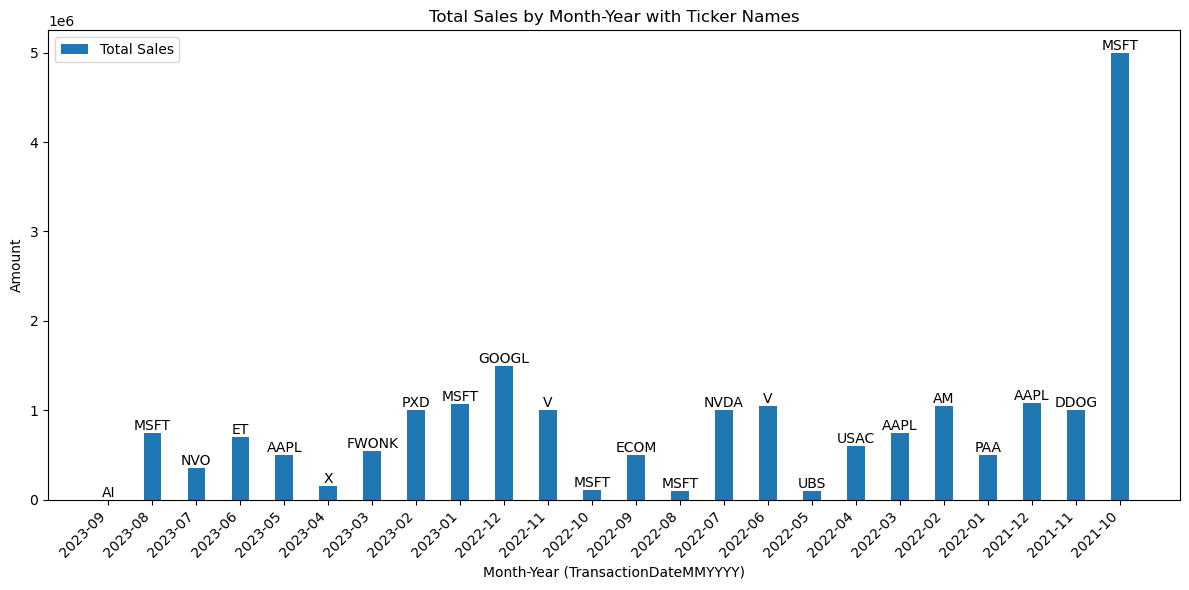

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import when

# Replace NULL values in sorted_df with 0 for TotalPurchases
sorted_df = sorted_df.fillna(0, subset=["TotalSales"])

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
pandas_df = sorted_df.limit(24).toPandas()

# Plot total purchases
plt.figure(figsize=(12, 6))
bars = plt.bar(
    pandas_df["TransactionDateMMYYYY"], pandas_df["TotalSales"], 
    width=0.4, label="Total Sales", align="center"
)

# Add ticker names as data labels above the bars
for i, bar in enumerate(bars):
    ticker = pandas_df["TickerSale"].iloc[i]
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 100, ticker, ha="center", va="bottom")

plt.xlabel("Month-Year (TransactionDateMMYYYY)")
plt.ylabel("Amount")
plt.title("Total Sales by Month-Year with Ticker Names")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
from pyspark.sql.functions import month, year, col

# Filter the DataFrame to include only records with Purchase transactions in January 2023
january_purchases_df = df.filter((year(df["TransactionDate"]) == 2023) & (month(df["TransactionDate"]) == 1) & (df["Transaction"] == "Purchase"))

# Extract the unique tickers from the filtered DataFrame
january_purchases_tickers = january_purchases_df.select("Ticker").distinct()

# Show the tickers where there was a purchase in January 2023
january_purchases_tickers.show()

+------+
|Ticker|
+------+
|  HUBS|
|   MMM|
| RHHBY|
|  MTCH|
| DNTUY|
|  FLNG|
|  FMAO|
|  AAPL|
|  TTWO|
|     F|
|   SYY|
|   EQR|
|   SPG|
|   HLN|
| SSDOY|
| TOSYY|
|   DEO|
|  MNST|
|   JPM|
|  EXAS|
+------+
only showing top 20 rows



In [12]:
from pyspark.sql.functions import month, year, col, sum

# Filter the DataFrame to include only records with Purchase transactions in January 2023
january_purchases_df = df.filter((year(df["TransactionDate"]) == 2023) & (month(df["TransactionDate"]) == 1) & (df["Transaction"] == "Purchase"))

# Calculate the total amount purchased in January 2023
total_amount_january = january_purchases_df.agg(sum("Amount")).collect()[0][0]

# Calculate the percentage of the total amount for each unique ticker
percentage_distribution_df = january_purchases_df.groupBy("Ticker").agg(
    ((sum("Amount") / total_amount_january) * 100).alias("Percentage")
)

# Show the percentage distribution
percentage_distribution_df.show()


+------+-------------------+
|Ticker|         Percentage|
+------+-------------------+
|  HUBS|0.10349965310555828|
|   MMM|0.10349965310555828|
| RHHBY|  1.551047248987492|
|  MTCH|0.10349965310555828|
| DNTUY|0.10349965310555828|
|  FLNG|0.20699930621111656|
|  FMAO|0.10349965310555828|
|  AAPL|0.10349965310555828|
|  TTWO|0.10349965310555828|
|     F|  1.551047248987492|
|   SYY|0.10349965310555828|
|   EQR|0.10349965310555828|
|   SPG|  1.551047248987492|
|   HLN|0.10349965310555828|
| SSDOY|0.10349965310555828|
| TOSYY|0.10349965310555828|
|   DEO| 1.7580465551986086|
|  MNST|0.10349965310555828|
|   JPM|0.10349965310555828|
|  EXAS|0.10349965310555828|
+------+-------------------+
only showing top 20 rows



In [13]:
percentage_distribution_df.agg(sum("Percentage")).collect()

[Row(sum(Percentage)=99.99999999999999)]

In [14]:
import yfinance as yf
import pandas as pd

# Allocate the initial investment based on the percentage distribution
initial_investment = 10000
percentage_distribution = percentage_distribution_df.collect()

# Create a dictionary to store the allocated amount for each ticker
allocation = {}
for row in percentage_distribution:
    ticker = row['Ticker']
    percentage = row['Percentage'] / 100  # Convert percentage to decimal
    allocated_amount = initial_investment * percentage
    allocation[ticker] = allocated_amount

# Retrieve historical stock prices for each ticker from Yahoo Finance
start_date = '2023-01-01'
end_date = '2023-06-30'

stock_data = {}
for ticker in allocation.keys():
    stock = yf.Ticker(ticker)
    historical_data = stock.history(start=start_date, end=end_date)
    stock_data[ticker] = historical_data

# Calculate the value of the portfolio for each day
portfolio_value = pd.DataFrame(index=stock_data[next(iter(stock_data))].index)
portfolio_value['Portfolio'] = 0

for ticker, historical_data in stock_data.items():
    allocation_amount = allocation[ticker]
    portfolio_value['Portfolio'] += (historical_data['Close'] / historical_data['Close'].iloc[0]) * allocation_amount

# Calculate the portfolio growth
initial_portfolio_value = portfolio_value['Portfolio'].iloc[0]
portfolio_growth = (portfolio_value['Portfolio'] - initial_portfolio_value) / initial_portfolio_value

# Print the portfolio growth
print(portfolio_growth)

Date
2023-01-03 00:00:00-05:00    0.000000
2023-01-04 00:00:00-05:00    0.018717
2023-01-05 00:00:00-05:00    0.009010
2023-01-06 00:00:00-05:00    0.035123
2023-01-09 00:00:00-05:00    0.038921
                               ...   
2023-06-23 00:00:00-04:00    0.112563
2023-06-26 00:00:00-04:00    0.111910
2023-06-27 00:00:00-04:00    0.130649
2023-06-28 00:00:00-04:00    0.133817
2023-06-29 00:00:00-04:00    0.139164
Name: Portfolio, Length: 123, dtype: float64


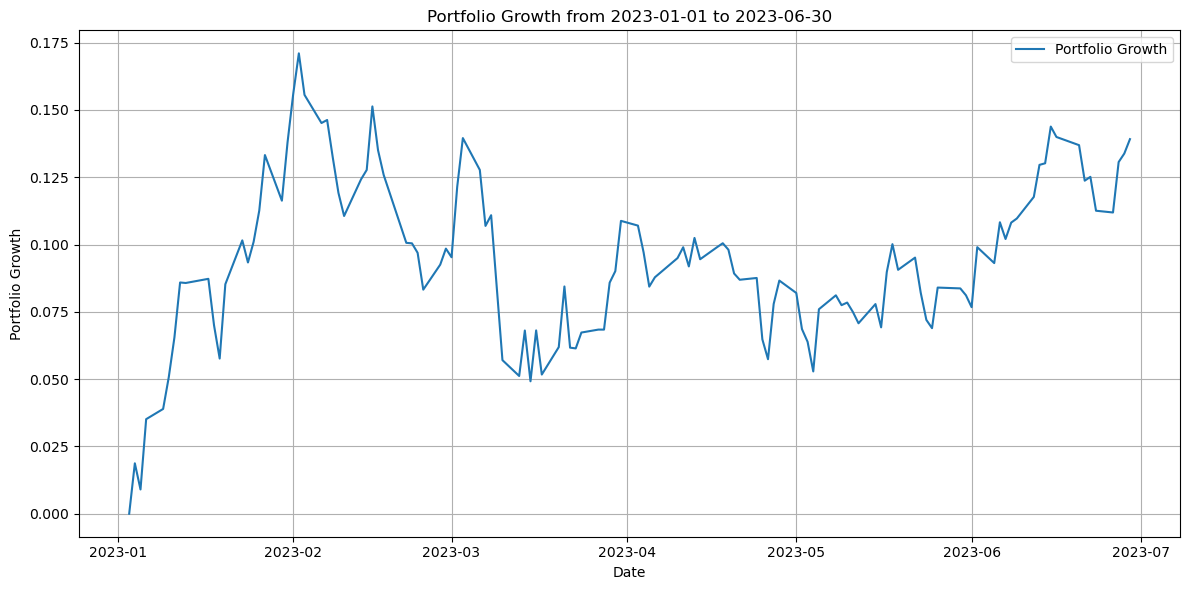

In [15]:
import matplotlib.pyplot as plt

# Plot the portfolio growth as a line chart
plt.figure(figsize=(12, 6))
plt.plot(portfolio_growth.index, portfolio_growth, label="Portfolio Growth")
plt.xlabel("Date")
plt.ylabel("Portfolio Growth")
plt.title("Portfolio Growth from 2023-01-01 to 2023-06-30")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

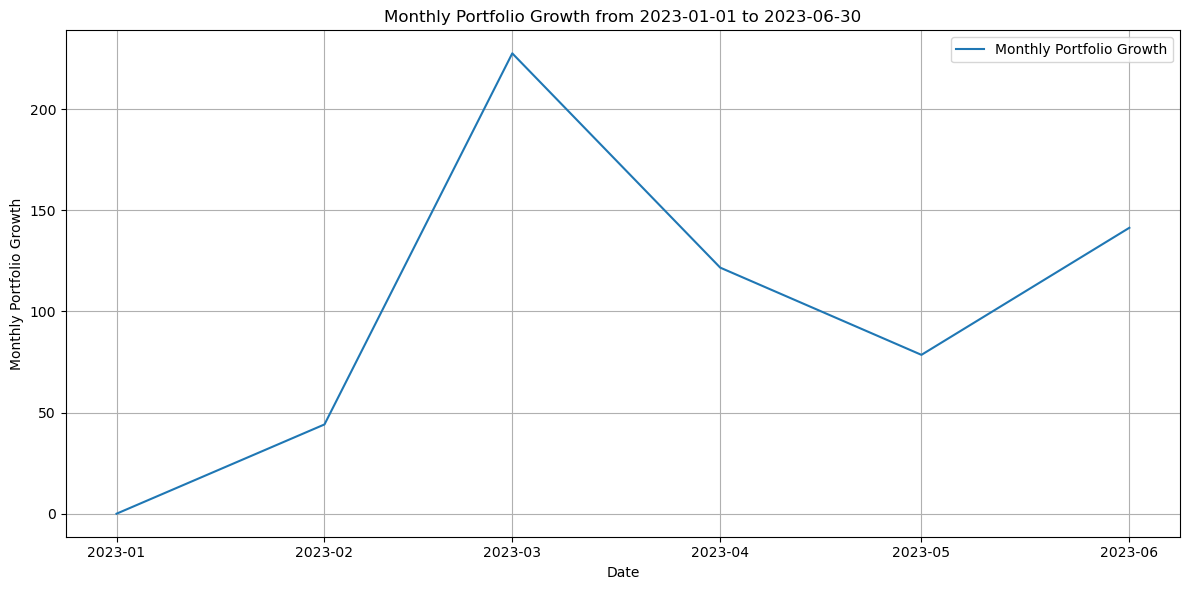

In [17]:
import yfinance as yf
import pandas as pd
from pyspark.sql.functions import month, year, col, sum
import matplotlib.pyplot as plt

# Define the time frame
start_date = '2023-01-01'
end_date = '2023-06-30'

# Create a list to store the monthly portfolio growth
monthly_portfolio_growth = []

# Initialize the initial investment and percentage distribution
initial_investment = 10000  # USD
percentage_distribution = percentage_distribution_df.collect()

# Create a dictionary to store the allocated amount for each ticker
allocation = {}

# Iterate through each month in the time frame
current_date = pd.to_datetime(start_date)
while current_date <= pd.to_datetime(end_date):
    # Filter the DataFrame to include only records with Purchase transactions for the current month
    current_month_purchases_df = df.filter(
        (year(df["TransactionDate"]) == current_date.year) &
        (month(df["TransactionDate"]) == current_date.month) &
        (df["Transaction"] == "Purchase")
    )

    # Calculate the sum of purchases for each ticker for the current month
    sum_purchases_by_ticker = current_month_purchases_df.groupBy("Ticker").agg(sum("Amount").alias("TotalPurchases"))

    # Calculate the total amount purchased for the current month
    total_purchases_current_month = sum_purchases_by_ticker.agg(sum("TotalPurchases")).collect()[0][0]

    # Calculate the new percentage distribution for each ticker by cumulating with the previous month's purchases
    if not allocation:
        # For the first month, use the initial percentage distribution
        for row in percentage_distribution:
            ticker = row['Ticker']
            percentage = row['Percentage'] / 100
            allocated_amount = initial_investment * percentage
            allocation[ticker] = allocated_amount
    else:
        # For subsequent months, rebalance based on the current month's purchases
        for row in percentage_distribution:
            ticker = row['Ticker']
            percentage = row['Percentage'] / 100
            allocated_amount = (total_purchases_current_month or 0) * percentage
            allocation[ticker] = allocated_amount

    # Retrieve historical stock prices for each ticker from Yahoo Finance
    stock_data = {}
    for ticker in allocation.keys():
        stock = yf.Ticker(ticker)
        historical_data = stock.history(start=start_date, end=end_date)
        stock_data[ticker] = historical_data

    # Calculate the value of the portfolio for the current month
    portfolio_value = 0
    for ticker, historical_data in stock_data.items():
        allocated_amount = allocation[ticker]
        if not historical_data.empty:
            # Use the closing price for the current month
            current_price = historical_data['Close'].iloc[0]
            portfolio_value += (current_price / historical_data['Close'].iloc[0]) * allocated_amount

    # Calculate the portfolio growth for the current month
    if len(monthly_portfolio_growth) == 0:
        initial_portfolio_value = portfolio_value
    monthly_portfolio_growth.append((current_date, (portfolio_value - initial_portfolio_value) / initial_portfolio_value))

    # Move to the next month
    current_date = current_date + pd.DateOffset(months=1)

# Convert the list of monthly portfolio growth to a Pandas DataFrame
monthly_portfolio_growth_df = pd.DataFrame(monthly_portfolio_growth, columns=["Date", "Portfolio Growth"])

# Plot the monthly portfolio growth as a line chart
plt.figure(figsize=(12, 6))
plt.plot(monthly_portfolio_growth_df["Date"], monthly_portfolio_growth_df["Portfolio Growth"], label="Monthly Portfolio Growth")
plt.xlabel("Date")
plt.ylabel("Monthly Portfolio Growth")
plt.title("Monthly Portfolio Growth from 2023-01-01 to 2023-06-30")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()